# EigenTorch Examples

In [35]:
import spdnn
import torch
import eigenfunctions as eF
import eigenoptim as eOptim
import matplotlib.pyplot as plt

In [37]:
## Generate Example features
s1 = 5
s2 = 3
Xdat = torch.rand(s1, s1)
X = Xdat @ Xdat.t()
tgt = torch.rand(s2, s2)
tgt = tgt @ tgt.t()
Wdat = torch.rand(s1, s1)
e, v = torch.eig(Wdat, eigenvectors=True)
Wdat = v[:s2]
W = spdnn.StiefelParameter(Wdat.clone().detach().requires_grad_(True))
We = torch.nn.Parameter(Wdat.clone().detach().requires_grad_(True))

## BiMap Example
___Demonstrate that output features are SPD and that weights remain semi-orthogonal after update.  Also demonstrate convergence.___

BiMap Output: 
	tensor([[1.0090, 0.4185, 0.6895],
        [0.4185, 0.5323, 0.3048],
        [0.6895, 0.3048, 1.0728]], grad_fn=<BiMapBackward>)
Euclidean Output: 
	tensor([[0.9106, 0.1914, 0.6001],
        [0.1914, 0.3203, 0.1151],
        [0.6001, 0.1151, 0.6337]], grad_fn=<MmBackward>)
Target: 
	tensor([[0.8436, 0.5813, 0.9163],
        [0.5813, 0.8229, 0.4672],
        [0.9163, 0.4672, 1.0592]])


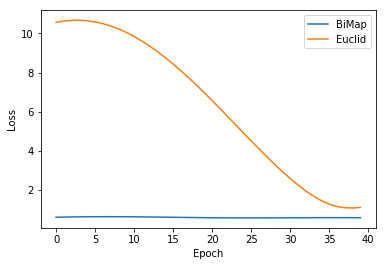

In [48]:
optim = eOptim.StiefelOpt([W], lr=0.0001)
optim_e = torch.optim.SGD([We], lr=0.0001)
bimap_func = eF.BiMap.apply
spd_arr = []
wne_arr = []
wor_arr = []
loss_arr = []
loss_e_arr = []

def check_spd(mat1):
    """
    check for spd by checking for positive norms of submatrices X[0:idx, 0:idx] where 0 < idx <= rank(X)
    Also check for symmetry.
    """
    result = True
    for idx in range(1, mat1.shape[0]):
        norm_val = mat1[:idx, :idx].norm()
        if norm_val <= 0.0:
            result = False
        for midx in range(idx, mat1.shape[0]):
            if (mat1[idx, midx] - mat1[midx, idx]) > 1e-4:
                result = False
    return result

def check_sortho(mat1):
    """
    Check to make sure matrix is semi-orthogonal 
    """
    tmat = mat1 @ mat1.t()
    idxs = torch.ones(3).diag() == 0
    valid = (tmat[idxs] < 1e-6).all()
    if not valid:
        print(tmat)
    return valid

# Loop through weight updates and check parameters and outputs
for epoch in range(40):
    W_old = W.clone().detach()
    # BiMap output and loss
    output = bimap_func(X, W)
    output_e = We.mm(X.mm(We.t()))
    loss = (output - tgt).norm()
    loss_arr.append(loss.item())
    loss.backward()
    # Euclidean bilinear output and loss
    loss_e = (output_e - tgt).norm()
    loss_e_arr.append(loss_e.item())
    loss_e.backward()
    optim.step()
    optim_e.step()
    # Update Arrays for checking properties
    spd_arr.append(check_spd(output))
    wne_arr.append((W == W_old).sum() == 0)
    wor_arr.append(check_sortho(W))

# Ensure Parameters actually updated
assert(torch.tensor(wne_arr).all())
# Ensure updated Parameters are semi-orthogonal
assert(torch.tensor(wor_arr).all())
# Ensure Output is SPD
assert(torch.tensor(spd_arr).all())
# Plot Loss over time
plt.plot(loss_arr)
plt.plot(loss_e_arr)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["BiMap", "Euclid"])
print("BiMap Output: \n\t{:s}".format(output.__repr__()))
print("Euclidean Output: \n\t{:s}".format(output_e.__repr__()))
print("Target: \n\t{:s}".format(tgt.__repr__()))
    
    



## ReEig Example: Demonstrate effect of eigenvalue thresholding

In [43]:
tgt = X.clone()
X = output.clone().detach.requies_grad(False)
min_eval = torch.eig(tgt)[0][:, 0][0]
min_val = evals.min()

tensor([2.2538e+00, 3.9497e-05, 4.7189e-01])
